In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import pickle
import os
from scipy import signal
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

In [2]:
class EEGEmotionClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=50)
        self.model = None
        self.feature_names = []
        
    def extract_features(self, eeg_data, sampling_rate=128):
        """
        EEG sinyallerinden özellik çıkarımı
        """
        features = []
        
        for channel in range(eeg_data.shape[0]):
            channel_data = eeg_data[channel, :]
            
            # Temel istatistiksel özellikler
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            var_val = np.var(channel_data)
            skew_val = skew(channel_data)
            kurt_val = kurtosis(channel_data)
            
            # Frekans domain özellikleri
            freqs, psd = signal.welch(channel_data, sampling_rate, nperseg=128)
            
            # Delta (0.5-4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30-50 Hz)
            delta_power = np.mean(psd[(freqs >= 0.5) & (freqs <= 4)])
            theta_power = np.mean(psd[(freqs >= 4) & (freqs <= 8)])
            alpha_power = np.mean(psd[(freqs >= 8) & (freqs <= 13)])
            beta_power = np.mean(psd[(freqs >= 13) & (freqs <= 30)])
            gamma_power = np.mean(psd[(freqs >= 30) & (freqs <= 50)])
            
            # Relatif güçler
            total_power = np.sum(psd)
            delta_rel = delta_power / total_power
            theta_rel = theta_power / total_power
            alpha_rel = alpha_power / total_power
            beta_rel = beta_power / total_power
            gamma_rel = gamma_power / total_power
            
            # Spektral kenar frekansı
            spectral_edge = freqs[np.where(np.cumsum(psd) >= 0.95 * np.sum(psd))[0][0]]
            
            channel_features = [
                mean_val, std_val, var_val, skew_val, kurt_val,
                delta_power, theta_power, alpha_power, beta_power, gamma_power,
                delta_rel, theta_rel, alpha_rel, beta_rel, gamma_rel,
                spectral_edge
            ]
            
            features.extend(channel_features)
            
        return np.array(features)
    
    def create_feature_names(self, n_channels):
        """Özellik isimlerini oluştur"""
        feature_types = [
            'mean', 'std', 'var', 'skew', 'kurtosis',
            'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power',
            'delta_rel', 'theta_rel', 'alpha_rel', 'beta_rel', 'gamma_rel',
            'spectral_edge'
        ]
        
        names = []
        for ch in range(n_channels):
            for feat in feature_types:
                names.append(f'ch{ch}_{feat}')
        
        return names
    
    def generate_synthetic_data(self, n_samples=1000, n_channels=14, signal_length=1024):
        """
        Demonstration için sentetik EEG verisi oluştur
        """
        np.random.seed(42)
        
        X_features = []
        y_labels = []
        
        # 4 duygu sınıfı: 0=sakin, 1=mutlu, 2=üzgün, 3=öfkeli
        emotions = ['calm', 'happy', 'sad', 'angry']
        
        for i in range(n_samples):
            # Rastgele duygu sınıfı seç
            emotion = np.random.randint(0, 4)
            
            # Her duygu için farklı frekans karakteristikleri
            if emotion == 0:  # sakin - yüksek alpha
                alpha_boost = 2.0
                beta_boost = 0.5
            elif emotion == 1:  # mutlu - yüksek beta
                alpha_boost = 1.0
                beta_boost = 2.0
            elif emotion == 2:  # üzgün - yüksek delta/theta
                alpha_boost = 0.5
                beta_boost = 0.7
            else:  # öfkeli - yüksek gamma
                alpha_boost = 0.8
                beta_boost = 1.5
            
            # EEG sinyali oluştur
            eeg_data = np.zeros((n_channels, signal_length))
            
            for ch in range(n_channels):
                # Farklı frekans bileşenleri
                delta = np.sin(2 * np.pi * 2 * np.linspace(0, 8, signal_length)) * np.random.uniform(0.5, 1.5)
                theta = np.sin(2 * np.pi * 6 * np.linspace(0, 8, signal_length)) * np.random.uniform(0.5, 1.5)
                alpha = np.sin(2 * np.pi * 10 * np.linspace(0, 8, signal_length)) * alpha_boost * np.random.uniform(0.8, 1.2)
                beta = np.sin(2 * np.pi * 20 * np.linspace(0, 8, signal_length)) * beta_boost * np.random.uniform(0.8, 1.2)
                
                # Gürültü ekle
                noise = np.random.normal(0, 0.1, signal_length)
                
                eeg_data[ch, :] = delta + theta + alpha + beta + noise
            
            # Özellikleri çıkar
            features = self.extract_features(eeg_data)
            X_features.append(features)
            y_labels.append(emotion)
        
        return np.array(X_features), np.array(y_labels), emotions
    
    def train(self, X, y, test_size=0.2):
        """Modeli eğit"""
        print("Özellik çıkarımı tamamlandı. Özellik sayısı:", X.shape[1])
        
        # Veriyi böl
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Normalizasyon
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Boyut azaltma
        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)
        
        print(f"PCA sonrası özellik sayısı: {X_train_pca.shape[1]}")
        print(f"Açıklanan varyans: %{self.pca.explained_variance_ratio_.sum()*100:.2f}")
        
        # Model eğitimi - Random Forest
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        
        print("Model eğitimi başlıyor...")
        self.model.fit(X_train_pca, y_train)
        
        # Tahmin ve değerlendirme
        y_pred = self.model.predict(X_test_pca)
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nTest Doğruluğu: %{accuracy*100:.2f}")
        
        return {
            'accuracy': accuracy,
            'y_test': y_test,
            'y_pred': y_pred,
            'X_test_pca': X_test_pca
        }
    
    def plot_results(self, results, emotion_names):
        """Sonuçları görselleştir"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Confusion Matrix
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=emotion_names, yticklabels=emotion_names, ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')
        
        # Feature Importance
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]
        
        axes[0,1].bar(range(len(indices)), importances[indices])
        axes[0,1].set_title('Top 20 Feature Importances')
        axes[0,1].set_xlabel('PCA Component')
        axes[0,1].set_ylabel('Importance')
        
        # PCA Visualization (first 2 components)
        X_test_pca = results['X_test_pca']
        for i, emotion in enumerate(emotion_names):
            mask = results['y_test'] == i
            axes[1,0].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                            label=emotion, alpha=0.7)
        axes[1,0].set_title('PCA Visualization (First 2 Components)')
        axes[1,0].set_xlabel('PC1')
        axes[1,0].set_ylabel('PC2')
        axes[1,0].legend()
        
        # Accuracy by Class
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, _ = precision_recall_fscore_support(
            results['y_test'], results['y_pred'], average=None
        )
        
        x_pos = np.arange(len(emotion_names))
        axes[1,1].bar(x_pos, f1, alpha=0.7)
        axes[1,1].set_title('F1-Score by Emotion')
        axes[1,1].set_xlabel('Emotion')
        axes[1,1].set_ylabel('F1-Score')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(emotion_names)
        
        plt.tight_layout()
        plt.savefig('eeg_emotion_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return fig
    
    def save_model(self, filepath='eeg_emotion_model.pkl'):
        """Modeli kaydet"""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'pca': self.pca,
            'feature_names': self.feature_names
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model kaydedildi: {filepath}")
    
    def load_model(self, filepath='eeg_emotion_model.pkl'):
        """Modeli yükle"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.pca = model_data['pca']
        self.feature_names = model_data['feature_names']
        
        print(f"Model yüklendi: {filepath}")


=== EEG Tabanlı Duygu Tanıma Sistemi ===

Sentetik EEG verisi oluşturuluyor...
Veri boyutu: (2000, 224)
Duygu sınıfları: ['calm', 'happy', 'sad', 'angry']
Sınıf dağılımı: [501 481 520 498]

Özellik çıkarımı tamamlandı. Özellik sayısı: 224
PCA sonrası özellik sayısı: 50
Açıklanan varyans: %83.89
Model eğitimi başlıyor...

Test Doğruluğu: %100.00

Sonuçlar görselleştiriliyor...


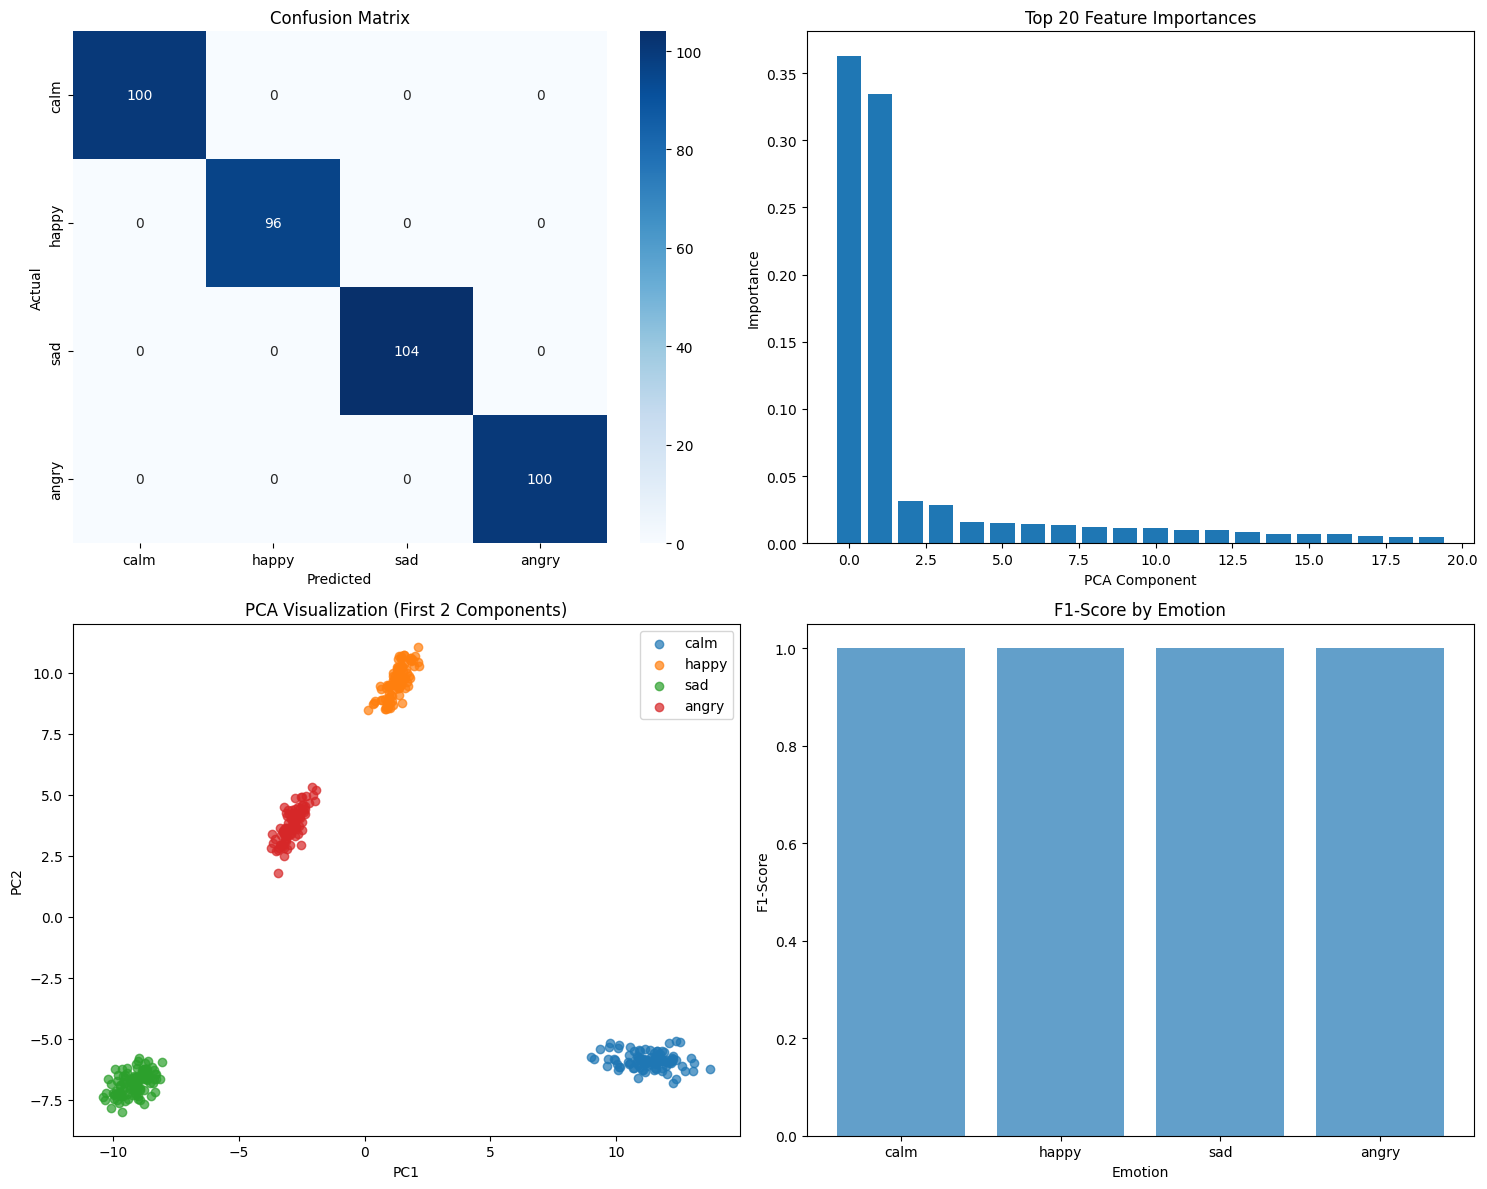

Model kaydedildi: eeg_emotion_model.pkl

=== DETAYLI RAPOR ===
              precision    recall  f1-score   support

        calm       1.00      1.00      1.00       100
       happy       1.00      1.00      1.00        96
         sad       1.00      1.00      1.00       104
       angry       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


=== ÖRNEK TAHMİN ===
Gerçek duygu: sad
Tahmin edilen: sad
Olasılıklar:
  calm: %6.93
  happy: %3.96
  sad: %82.31
  angry: %6.79


In [3]:
def main():
    print("=== EEG Tabanlı Duygu Tanıma Sistemi ===\n")
    
    # Classifier oluştur
    classifier = EEGEmotionClassifier()
    
    # Sentetik veri oluştur (gerçek projede DEAP dataset kullanılır)
    print("Sentetik EEG verisi oluşturuluyor...")
    X, y, emotion_names = classifier.generate_synthetic_data(n_samples=2000)
    
    print(f"Veri boyutu: {X.shape}")
    print(f"Duygu sınıfları: {emotion_names}")
    print(f"Sınıf dağılımı: {np.bincount(y)}\n")
    
    # Özellik isimlerini oluştur
    classifier.feature_names = classifier.create_feature_names(n_channels=14)
    
    # Model eğitimi
    results = classifier.train(X, y)
    
    # Sonuçları görselleştir
    print("\nSonuçlar görselleştiriliyor...")
    classifier.plot_results(results, emotion_names)
    
    # Modeli kaydet
    classifier.save_model()
    
    # Detaylı rapor
    print("\n=== DETAYLI RAPOR ===")
    print(classification_report(results['y_test'], results['y_pred'], 
                              target_names=emotion_names))
    
    # Örnek tahmin
    print("\n=== ÖRNEK TAHMİN ===")
    sample_idx = 0
    sample_features = X[sample_idx:sample_idx+1]
    sample_scaled = classifier.scaler.transform(sample_features)
    sample_pca = classifier.pca.transform(sample_scaled)
    
    prediction = classifier.model.predict(sample_pca)[0]
    probability = classifier.model.predict_proba(sample_pca)[0]
    
    print(f"Gerçek duygu: {emotion_names[y[sample_idx]]}")
    print(f"Tahmin edilen: {emotion_names[prediction]}")
    print("Olasılıklar:")
    for i, prob in enumerate(probability):
        print(f"  {emotion_names[i]}: %{prob*100:.2f}")

if __name__ == "__main__":
    main()